[INFO] Found labels: [ 1  3 12 24 34 40]
[INFO] Label 3 → 4 connected components

0: 1024x1024 1 0, 4573.9ms
Speed: 11.3ms preprocess, 4573.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


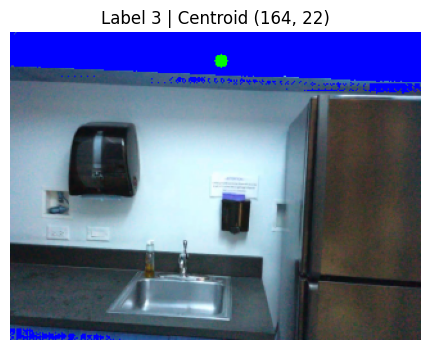


0: 1024x1024 1 0, 4577.2ms
Speed: 10.3ms preprocess, 4577.2ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


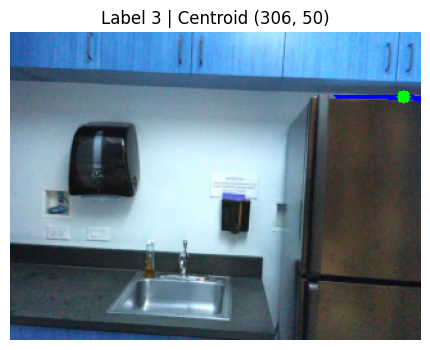


0: 1024x1024 1 0, 4605.5ms
Speed: 11.3ms preprocess, 4605.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


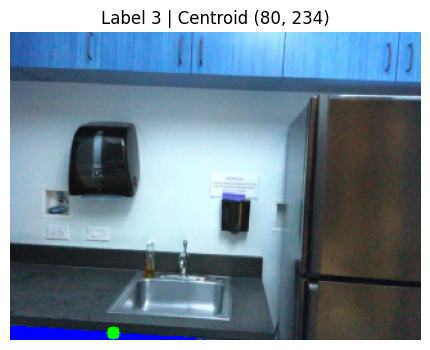


0: 1024x1024 1 0, 4549.7ms
Speed: 11.0ms preprocess, 4549.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)


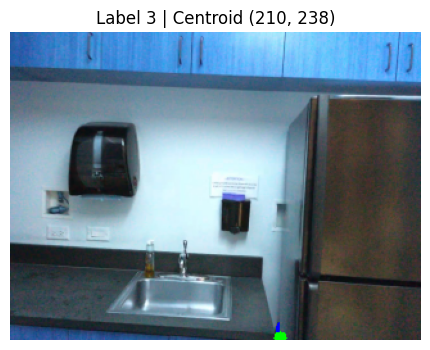

[INFO] Label 12 → 1 connected components

0: 1024x1024 1 0, 4527.9ms
Speed: 10.0ms preprocess, 4527.9ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


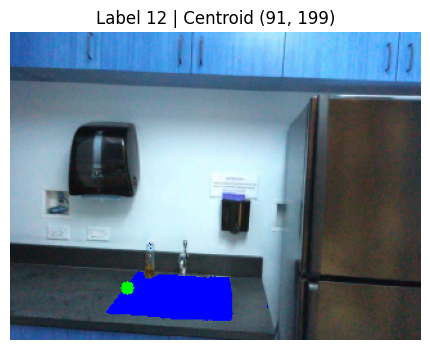

[INFO] Label 24 → 2 connected components

0: 1024x1024 1 0, 4587.5ms
Speed: 10.4ms preprocess, 4587.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


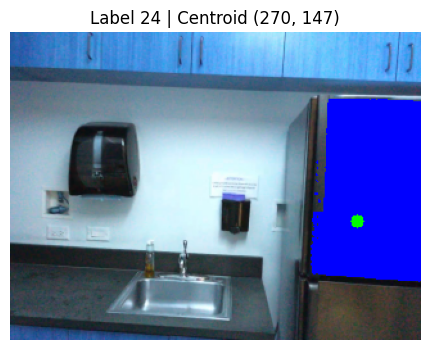


0: 1024x1024 1 0, 4580.4ms
Speed: 10.8ms preprocess, 4580.4ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


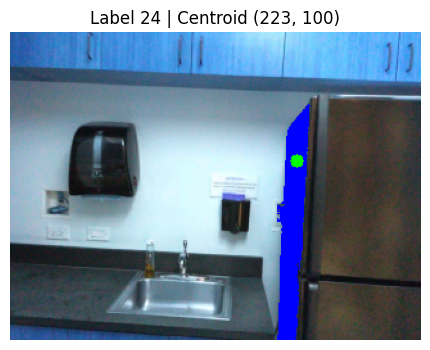

[INFO] Label 34 → 1 connected components

0: 1024x1024 1 0, 4624.0ms
Speed: 11.3ms preprocess, 4624.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


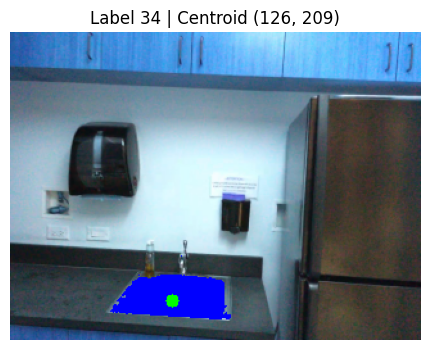

[INFO] Label 40 → 4 connected components

0: 1024x1024 1 0, 4667.0ms
Speed: 10.3ms preprocess, 4667.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)


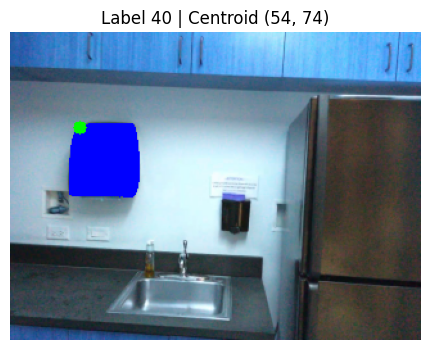


0: 1024x1024 1 0, 4488.1ms
Speed: 10.5ms preprocess, 4488.1ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


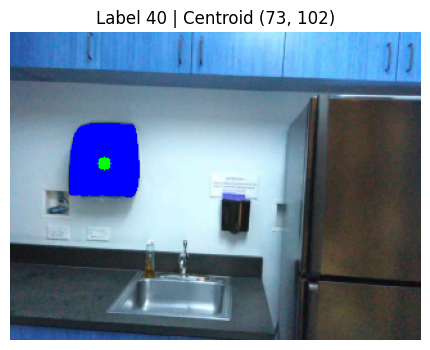


0: 1024x1024 1 0, 4530.7ms
Speed: 10.3ms preprocess, 4530.7ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)


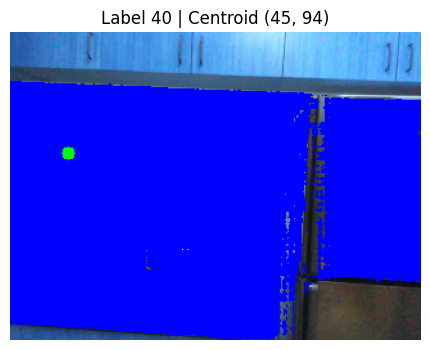


0: 1024x1024 1 0, 4576.9ms
Speed: 10.4ms preprocess, 4576.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)


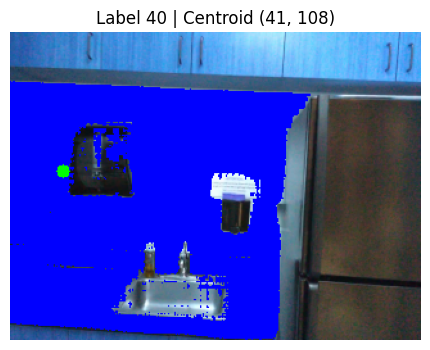

[INFO] Refinement complete.


In [1]:
# === Imports ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import SAM
from SamRefinement import SAM2Refiner

def rgb_to_class_index(rgb_image, class_colors, tolerance=5):
    h, w = rgb_image.shape[:2]
    class_map = np.zeros((h, w), dtype=np.int32)
    for class_idx, color in enumerate(class_colors):
        mask = np.all(np.abs(rgb_image - color) <= tolerance, axis=-1)
        class_map[mask] = class_idx
    return class_map

def labels_to_rgb(label_img,class_colors):
    """Convert label indices (H, W) to RGB image using predefined colormap."""
    sem_new = np.zeros((label_img.shape[0], label_img.shape[1], 3), dtype=np.uint8)
    for i in range(41):  # self.max_classes is 41
        sem_new[label_img == i] = class_colors[i]
    return sem_new
# === Static Paths ===
mapping = np.genfromtxt("nyu40_segmentation_mapping.csv", delimiter=",")[1:, 1:4]
class_colors = mapping
image_path = "./test_db/color/618.jpg"         # Path to RGB image
pseudo_mask_path = "./test_db/pseudo/618.png"   # Path to pseudo label (color)

pseudo_bgr = cv2.imread(pseudo_mask_path)
pseudo_rgb = cv2.cvtColor(pseudo_bgr, cv2.COLOR_BGR2RGB)
model_path = "sam2_b.pt"         # Path to SAM2 model weights

# === Load Inputs ===
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb= cv2.resize(image_rgb,(320,240),interpolation=cv2.INTER_AREA)
pseudo_mask = rgb_to_class_index(pseudo_rgb, class_colors)

# === Refine ===
refiner = SAM2Refiner(model_path=model_path)
refined_mask = refiner.refine(image_rgb, pseudo_mask)




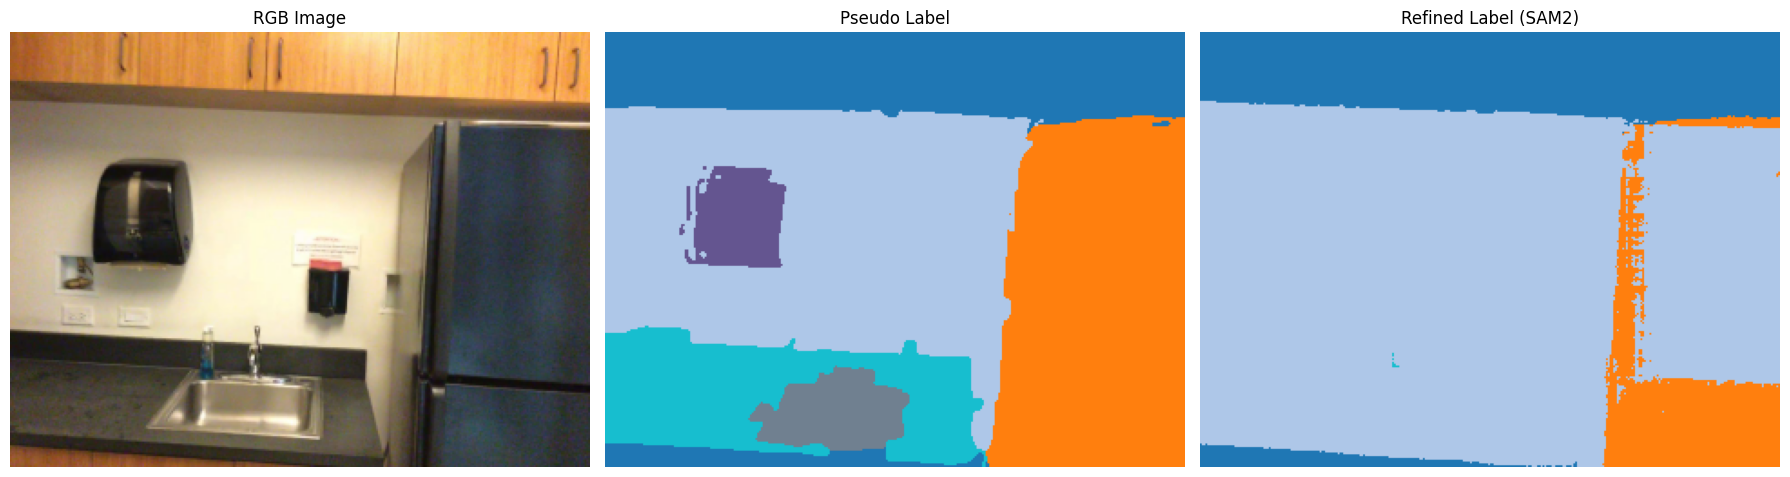

In [2]:
# === Display ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(image_rgb)
axs[0].set_title("RGB Image")
axs[0].axis("off")

axs[1].imshow(pseudo_rgb)
axs[1].set_title("Pseudo Label")
axs[1].axis("off")

axs[2].imshow(labels_to_rgb(refined_mask,class_colors))
axs[2].set_title("Refined Label (SAM2)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [2]:
import numpy as np

def compute_iou(pred_mask: np.ndarray, gt_mask: np.ndarray, num_classes: int) -> float:
    """
    Compute Mean IoU between predicted mask and ground truth.

    Args:
        pred_mask (np.ndarray): Predicted mask (H, W).
        gt_mask (np.ndarray): Ground truth mask (H, W).
        num_classes (int): Number of semantic classes.

    Returns:
        float: Mean IoU across classes.
    """
    ious = []

    for cls in range(1, num_classes):  # Skip background (class 0)
        pred_cls = pred_mask == cls
        gt_cls = gt_mask == cls

        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()

        if union == 0:
            continue  # Class not present in GT or prediction

        iou = intersection / union
        ious.append(iou)

    if not ious:
        return 0.0
    return np.mean(ious)

# === Assuming you have these ===
# pseudo_mask: predicted from RGB pseudo color map
# refined_mask: result from SAM2Refiner
# gt_mask: ground truth label map (with class indices)

num_classes = 41  # NYUv2 or similar
gt_mask = cv2.imread("./test_db/GT/618.png")
gt_rgb = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2RGB)
gt_mask= cv2.resize(gt_rgb,(320,240),interpolation=cv2.INTER_AREA)
gt_mask = rgb_to_class_index(gt_mask, class_colors)
miou_pseudo = compute_iou(pseudo_mask, gt_mask, num_classes)
miou_refined = compute_iou(refined_mask, gt_mask, num_classes)

print(f"Pseudo Label mIoU:  {miou_pseudo:.4f}")
print(f"Refined Label mIoU: {miou_refined:.4f}")

improvement = miou_refined - miou_pseudo
print(f"mIoU Improvement:   {improvement:+.4f}")


NameError: name 'rgb_to_class_index' is not defined

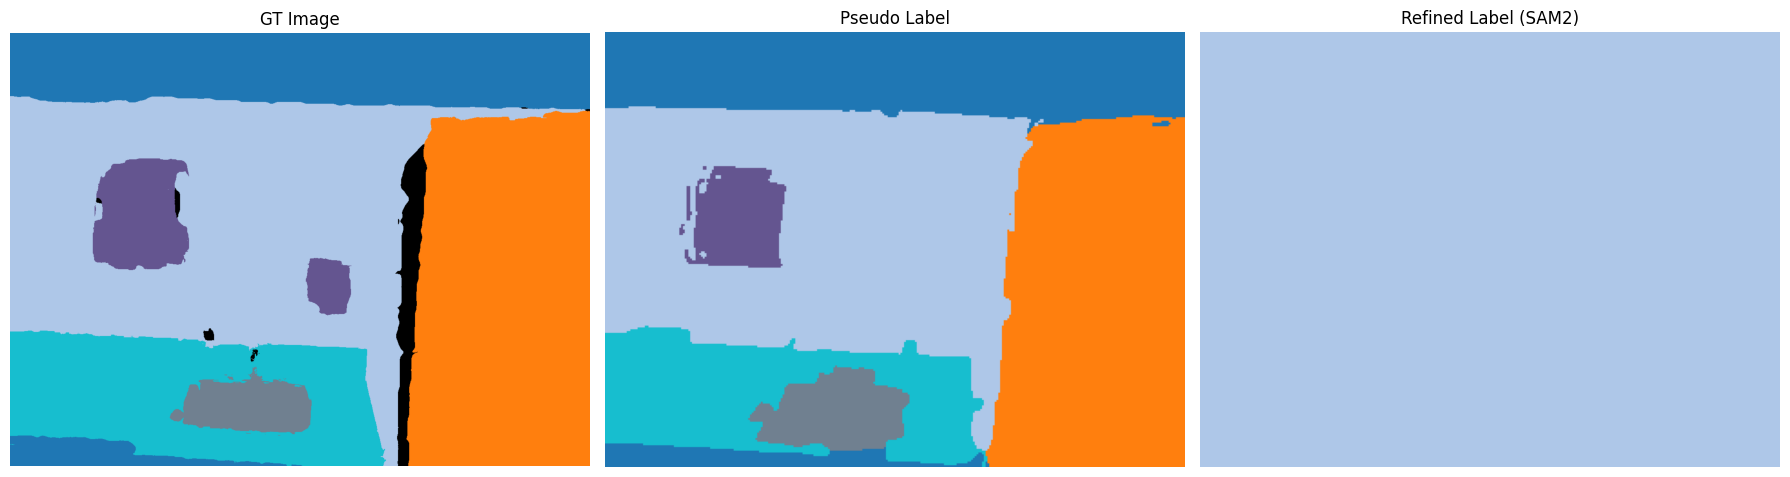

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(gt_rgb)
axs[0].set_title("GT Image")
axs[0].axis("off")

axs[1].imshow(pseudo_rgb)
axs[1].set_title("Pseudo Label")
axs[1].axis("off")

axs[2].imshow(labels_to_rgb(refined_mask,class_colors))
axs[2].set_title("Refined Label (SAM2)")
axs[2].axis("off")

plt.tight_layout()
plt.show()